# Fault plots

Final fault plots for the report. This will be the first plot in Section 3. Standard plots, and then interactive html plots for the web version of the report.

MW, 18/7/25

In [2]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd
import geopandas as gpd
import shapely
import rasterio

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
# Set up a dictionary for storms
storms = {
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
}

# Set up different colours for the storms
storm_colours = {
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
}

In [4]:
#Wind gust data
# Set up the path to the full wind gust data
full_wind_gust_file_path = "../saved_dfs/max_10m_wind_gusts_timeseries_DNO_areas_Apr_2024-Apr_2025.csv"

# Load in the full wind gust data
full_wind_gust_data = pd.read_csv(full_wind_gust_file_path, low_memory=False)

# Set "Unnamed: 0" as the index
full_wind_gust_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_wind_gust_data.index.name = "Time"

# Ensure this index is in datetime format
full_wind_gust_data.index = pd.to_datetime(full_wind_gust_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_wind_gust_data_daily = full_wind_gust_data.resample('D').max()

#Take GB max and crop to correct time period
full_wind_gust_data_daily =full_wind_gust_data_daily[(full_wind_gust_data_daily.index < '2025-04-01') & (full_wind_gust_data_daily.index >= '2024-04-01')].max(axis=1)


In [5]:
# Set uip the path to the full precip
full_accum_precip_file_path = "../saved_dfs/total_precip_timeseries_dno_areas_April_2024-April_2025.csv"

# Load in the full precip data
full_accum_precip_data = pd.read_csv(full_accum_precip_file_path, low_memory=False)

# Set "Unnamed: 0" as the index
full_accum_precip_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_accum_precip_data.index.name = "Time"

# Ensure this index is in datetime format
full_accum_precip_data.index = pd.to_datetime(full_accum_precip_data.index)

# Aggregate the data to daily frequency, by summing the values for each day
full_accum_precip_data_daily = full_accum_precip_data.resample('D').mean()

#Take GB mean and crop to correct time period
full_accum_precip_data_daily = full_accum_precip_data_daily[(full_accum_precip_data_daily.index < '2025-04-01') & (full_accum_precip_data_daily.index >= '2024-04-01')].mean(axis=1)
full_accum_precip_data_daily.head()

Time
2024-04-01     5.881967
2024-04-02     6.499228
2024-04-03     9.093253
2024-04-04     7.181843
2024-04-05    12.729941
Freq: D, dtype: float64

In [6]:
# Set uip the path to the full lightning data
full_lightning_file_path = "../saved_dfs/lightning_density_timeseries_DNO_areas_Apr_2024-Dec_2024.csv"

# Load in the full lightning data
full_lightning_data = pd.read_csv(full_lightning_file_path, low_memory=False)

# Set "Unnamed: 0" as the index
full_lightning_data.set_index("Unnamed: 0", inplace=True)

# rename the index as time
full_lightning_data.index.name = "Time"

# Ensure this index is in datetime format
full_lightning_data.index = pd.to_datetime(full_lightning_data.index)

#Take GB mean and crop to correct time period
full_lightning_data_daily = full_lightning_data[(full_lightning_data.index < '2025-04-01') & (full_lightning_data.index >= '2024-04-01')].max(axis=1)
full_lightning_data_daily.head()


Time
2024-04-01    0.002178
2024-04-02    0.000000
2024-04-03    0.000000
2024-04-04    0.000575
2024-04-05    0.000000
dtype: float64

In [7]:
# Load all fault data (already combined into one file and filtered to remove non-meteorological faults)
all_fault_data = pd.read_csv('../faults/fault_data/combined_weather_fault_data_normalised.csv', usecols=lambda x: not x.startswith("Unnamed"),)

#Drop NANs and enforce datetime format
all_fault_data = all_fault_data.dropna(subset=['Start date'])
all_fault_data['Start date'] = pd.to_datetime(
    all_fault_data['Start date']
)


In [8]:
#wind faults -- GB average across DNOs we have data for
#Select wind and fallen tree categories and convert CML field into float format
wind_faults = all_fault_data[all_fault_data['Category'].isin(['Wind', 'Trees'])].drop(['DNO', 'Population-weight customers affected', 'Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
wind_faults['Population-weight CML'] = wind_faults['Population-weight CML'].astype(str).str.replace(',', '').astype(float)

#Group by start date and region and sum
wind_faults = wind_faults.groupby(['Start date','Region'], as_index=False).sum()
#Normalise by maximium in each region -- to give relative impact of that event in that region in 2024-25
wind_faults['Normalised population-weighted CML'] = wind_faults.groupby('Region')['Population-weight CML'].transform(lambda x: x / x.max())
#Take mean across regions to give UK average severity on that date
wind_faults_gb = wind_faults.groupby(['Start date'])['Normalised population-weighted CML'].mean()
#Reindex to fill all days with zero if there are no faults on that day
wind_faults_gb = wind_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML

#Check head
wind_faults_gb.head()


2024-04-01    0.000000
2024-04-02    0.000297
2024-04-03    0.000572
2024-04-04    0.000711
2024-04-05    0.000477
Freq: D, Name: Normalised population-weighted CML, dtype: float64

In [9]:
#precip faults -- GB average across DNOs we have data for

#Select precip related categories and convert CML field into float format
precip_faults = all_fault_data[all_fault_data['Cause'].isin(['Rain', 'Flooding', 'Snow, Sleet and Blizzard', 'Freezing Fog and Frost', 'Ice'])].drop(['DNO', 'Population-weight customers affected', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
precip_faults['Population-weight CML'] = precip_faults['Population-weight CML'].astype(str).str.replace(',', '').astype(float)

#Normalise by maximium in each region -- to give relative impact of that event from that cause in that region in 2024-25
precip_faults = precip_faults.groupby(['Start date','Region', 'Cause'], as_index=False).sum()

#All faults -- copy and normalise by max, then take mean across regions
all_precip_faults_gb = precip_faults.copy()
all_precip_faults_gb['Normalised population-weighted CML'] = all_precip_faults_gb.groupby(['Region'])['Population-weight CML'].transform(lambda x: x / x.max())
all_precip_faults_gb = all_precip_faults_gb.groupby(['Start date'])['Normalised population-weighted CML'].mean()

#Different fault codes
#First find max within each regino
region_max_CML = precip_faults.groupby('Region')['Population-weight CML'].max()

# For each cause, normalise by the maximum CML from any cause in that region
flood_faults_gb = precip_faults[precip_faults['Cause'] == 'Flooding']
flood_faults_gb['Normalised population-weighted CML'] = flood_faults_gb['Population-weight CML'] / flood_faults_gb['Region'].map(region_max_CML)
flood_faults_gb = flood_faults_gb.groupby(['Start date'])['Normalised population-weighted CML'].mean()
rain_faults_gb = precip_faults[precip_faults['Cause'] == 'Rain']
rain_faults_gb['Normalised population-weighted CML'] = rain_faults_gb['Population-weight CML'] / rain_faults_gb['Region'].map(region_max_CML)
rain_faults_gb = rain_faults_gb.groupby(['Start date'])['Normalised population-weighted CML'].mean()
snow_faults_gb = precip_faults[precip_faults['Cause'] == 'Snow, Sleet and Blizzard']
snow_faults_gb['Normalised population-weighted CML'] = snow_faults_gb['Population-weight CML'] / snow_faults_gb['Region'].map(region_max_CML)
snow_faults_gb = snow_faults_gb.groupby(['Start date'])['Normalised population-weighted CML'].mean()
frost_faults_gb = precip_faults[precip_faults['Cause'] == 'Freezing Fog and Frost']
frost_faults_gb['Normalised population-weighted CML'] = frost_faults_gb['Population-weight CML'] / frost_faults_gb['Region'].map(region_max_CML)
frost_faults_gb = frost_faults_gb.groupby(['Start date'])['Normalised population-weighted CML'].mean()

#Reindex all causes
all_precip_faults_gb = all_precip_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
flood_faults_gb = flood_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
rain_faults_gb = rain_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
snow_faults_gb = snow_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
frost_faults_gb = frost_faults_gb.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML

#Check tail
all_precip_faults_gb.tail()

/var/folders/k9/wbf996vd0bqfx_k_3z8ytlq40000gq/T/ipykernel_39572/2836622907.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k9/wbf996vd0bqfx_k_3z8ytlq40000gq/T/ipykernel_39572/2836622907.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k9/wbf996vd0bqfx_k_3z8ytlq40000gq/T/ipykernel_39572/2836622907.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

2025-03-27    0.0
2025-03-28    0.0
2025-03-29    0.0
2025-03-30    0.0
2025-03-31    0.0
Freq: D, Name: Normalised population-weighted CML, dtype: float64

In [10]:
#Check that the sum of the components equals the total

# Sum the normalized CML for snow, flood, rain, and frost
combined_precip_faults = (flood_faults_gb +
                          rain_faults_gb +
                          snow_faults_gb +
                          frost_faults_gb)

# Check if the sum equals all_precip_faults_gb
check = combined_precip_faults == all_precip_faults_gb

# Check the result
print(check)

# Print the dates where the difference is larger than 0.05
difference = abs(combined_precip_faults - all_precip_faults_gb)
dates_with_large_diff = difference[difference > 0.05]
print(f"Dates with large differences (> 0.05):\n{dates_with_large_diff}")

2024-04-01    True
2024-04-02    True
2024-04-03    True
2024-04-04    True
2024-04-05    True
              ... 
2025-03-27    True
2025-03-28    True
2025-03-29    True
2025-03-30    True
2025-03-31    True
Freq: D, Name: Normalised population-weighted CML, Length: 365, dtype: bool
Dates with large differences (> 0.05):
2024-11-23    0.219407
2024-12-31    0.460685
2025-01-01    0.488948
2025-01-06    0.064083
Name: Normalised population-weighted CML, dtype: float64


In [11]:
# Identify the cause with the maximum fault for each date
causes = ['Flooding', 'Rain', 'Snow, Sleet, Blizzard', 'Freezing Fog, Frost', 'Ice']
lists_of_dates = {cause: [] for cause in causes}  # Create a dictionary to store lists for each cause

# Initialize lists for each cause
lists_of_dates = {cause: [] for cause in causes}

# Iterate through the data and assign dates to the lists
for date in all_precip_faults_gb.index:
    # Get the absolute values of the faults for each cause
    abs_flood = abs(flood_faults_gb.loc[date])
    abs_rain = abs(rain_faults_gb.loc[date])
    abs_snow = abs(snow_faults_gb.loc[date])
    abs_frost = abs(frost_faults_gb.loc[date])
    
    # Find the maximum of the four absolute values
    max_value = max(abs_flood, abs_rain, abs_snow, abs_frost)
    
    # If the max value is > 0.05, add the date to the corresponding cause's list
    if max_value > 0.025:
        if max_value == abs_flood:
            lists_of_dates['Flooding'].append(date)
        elif max_value == abs_rain:
            lists_of_dates['Rain'].append(date)
        elif max_value == abs_snow:
            lists_of_dates['Snow, Sleet, Blizzard'].append(date)
        elif max_value == abs_frost:
            lists_of_dates['Freezing Fog, Frost'].append(date)

# Print the lists of dates for each cause
for cause in causes:
    print(f"Dates for {cause} with a large absolute fault: {lists_of_dates[cause]}")

Dates for Flooding with a large absolute fault: [Timestamp('2024-04-09 00:00:00'), Timestamp('2024-11-27 00:00:00'), Timestamp('2025-01-01 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-25 00:00:00')]
Dates for Rain with a large absolute fault: [Timestamp('2024-05-07 00:00:00'), Timestamp('2024-05-22 00:00:00'), Timestamp('2024-05-28 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-07-05 00:00:00'), Timestamp('2024-08-23 00:00:00'), Timestamp('2024-09-22 00:00:00'), Timestamp('2024-09-24 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-10-16 00:00:00'), Timestamp('2024-11-18 00:00:00'), Timestamp('2024-11-25 00:00:00'), Timestamp('2024-12-18 00:00:00'), Timestamp('2024-12-22 00:00:00'), Timestamp('2025-01-26 00:00:00'), Timestamp('2025-01-27 00:00:00')]
Dates for Snow, Sleet, Blizzard with a large absolute fault: [Timestamp('2024-11-23 00:00:00'), Timestamp('2024-12-31 00:00:00'), Timestamp('2025-01-04 00:00:00'), Timestamp('2025-01-05 00:00:

In [12]:
#lightning faults -- GB average across DNOs we have data for
#Select lightning faults and convert CML field into float format
lightning_faults = all_fault_data[all_fault_data['Category'] == 'Lightning'].drop(['DNO', 'Population-weight customers affected', 'Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Normalised population-weighted CML', 'Customers affected', 'Normalised population-weighted customers affected', 'Voltage', 'Location', 'Latitude', 'Longitude'], axis=1)
lightning_faults['Population-weight CML'] = lightning_faults['Population-weight CML'].astype(str).str.replace(',', '').astype(float)
#Group by start date and region and sum
lightning_faults = lightning_faults.groupby(['Start date','Region'], as_index=False).sum()
#Normalise by maximium in each region -- to give relative impact of that event in that region in 2024-25
lightning_faults['Normalised population-weighted CML'] = lightning_faults.groupby('Region')['Population-weight CML'].transform(lambda x: x / x.max())
#Take mean across regions and reindex to fill days without faults with 0
lightning_faults_gb = lightning_faults.groupby(['Start date'])['Normalised population-weighted CML'].mean()
lightning_faults_gb = lightning_faults_gb.reindex(pd.date_range('2024-04-01','2024-12-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML

#Check head
lightning_faults_gb.head()


2024-04-01    0.000000
2024-04-02    0.000000
2024-04-03    0.000000
2024-04-04    0.000000
2024-04-05    0.331289
Freq: D, Name: Normalised population-weighted CML, dtype: float64

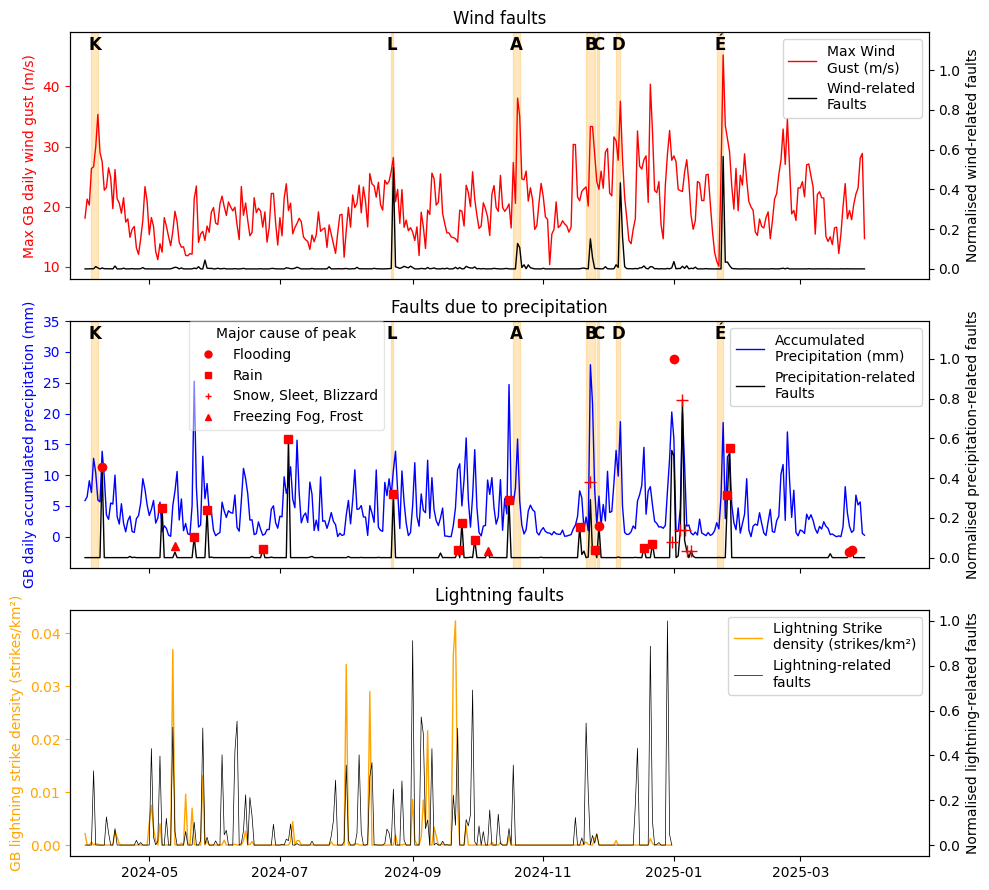

In [13]:
# Set up a figure with 3 rows and 1 column, shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Set up the axes
ax1 = axs[0]
ax1_b = axs[0].twinx()
ax2 = axs[1]
ax2_b = axs[1].twinx()
ax3 = axs[2]
ax3_b = axs[2].twinx()

#set x limits
ax1.set_xlim(pd.to_datetime('2024-03-25'),pd.to_datetime('2025-04-30'))
# Set the labels and title for the first subplot - wind
ax1_b.set_ylabel("Normalised wind-related faults")
ax1.set_ylabel("Max GB daily wind gust (m/s)", color='red')
ax1.tick_params(axis='y', colors='red')

# Set the labels and title for the second subplot - precip
ax2_b.set_ylabel("Normalised precipitation-related faults")
ax2.set_ylabel("GB daily accumulated precipitation (mm)", color='blue')
ax2.tick_params(axis='y', colors='blue')

# Set the labels and title for the second subplot - precip
ax3_b.set_ylabel("Normalised lightning-related faults")
ax3.set_ylabel("GB lightning strike density (strikes/km²)", color='orange')
ax3.tick_params(axis='y', colors='orange')

# plot wind gusts
ax1.plot(
    full_wind_gust_data_daily.index,
    full_wind_gust_data_daily,
    color='red',
    linestyle='-',
    lw=1,
    label='Max Wind\nGust (m/s)',
    )
ax1.set_ylim(8,49)

# plot wind related faults
ax1_b.plot(
    wind_faults_gb.index,
    wind_faults_gb,
    color='black',
    linestyle='-',
    lw=1,
    label='Wind-related\nFaults',
    )
ax1_b.set_ylim(-0.05,1.19)

# Create the legend
handles, labels = ax1.get_legend_handles_labels()
handles.extend(ax1_b.get_legend_handles_labels()[0])
labels.extend(ax1_b.get_legend_handles_labels()[1])
# Add the custom legend to the plot
ax1_b.legend(handles, labels, loc='upper right')

ax1_b.set_title('Wind faults')

# plot precip data
ax2.plot(
    full_accum_precip_data_daily.index,
    full_accum_precip_data_daily,
    color='blue',
    linestyle='-',
    lw=1,
    label='Accumulated\nPrecipitation (mm)',
    )
ax2.set_ylim(-4.99,35)

# plot precip related faults
ax2_b.plot(
    all_precip_faults_gb.index,
    all_precip_faults_gb,
    color='black',
    linestyle='-',
    lw=1,
    label='Precipitation-related\nFaults',
    zorder=100
    )
ax2_b.set_ylim(-0.05,1.19)

# Create the legend
handles, labels = ax2.get_legend_handles_labels()
handles.extend(ax2_b.get_legend_handles_labels()[0])
labels.extend(ax2_b.get_legend_handles_labels()[1])
# Add the custom legend to the plot
ax2.legend(handles, labels, loc='upper right')

symbols = ['o', 's', '+', '^']  # Symbol for each cause
# Add symbols on top of the peaks for each cause
for cause, symbol in zip(causes, symbols):
    for date in lists_of_dates[cause]:
        ms = 6
        # Find the corresponding value for each cause on the specific date
        if cause == 'Flooding':
            value = flood_faults_gb.loc[date]
        elif cause == 'Rain':
            value = rain_faults_gb.loc[date]
        elif cause == 'Snow, Sleet, Blizzard':
            value = snow_faults_gb.loc[date]
            ms = 9
        elif cause == 'Freezing Fog, Frost':
            value = frost_faults_gb.loc[date]

        # Plot the symbol (with specific markers) at the date
        ax2_b.plot(date, value, marker=symbol, color='red', markersize=ms, zorder=200)
    ax2_b.plot([], [], marker=symbol, color='red', markersize=5, linestyle="None", label=f"{cause}")[0]

# Create the legend
handles, labels = ax2_b.get_legend_handles_labels()
# Add the custom legend to the plot
ax2_b.legend(handles[1:], labels[1:], bbox_to_anchor=(0.13, 0.53), title='Major cause of peak', framealpha=0.5)

ax2_b.set_title('Faults due to precipitation')

# plot flood related faults
# ax2_b.plot(
#     flood_faults_gb.index,
#     flood_faults_gb,
#     color='black',
#     linestyle='--',
#     lw=1,
#     label='Flood-related Faults',
#     )
# ax2_b.set_ylim(-0.05,1.19)

# plot rain related faults
# ax2_b.plot(
#     rain_faults_gb.index,
#     rain_faults_gb,
#     color='black',
#     linestyle=(0, (1, 2.5)),
#     lw=1,
#     label='Rain-related Faults',
#     )
# ax2_b.set_ylim(-0.05,1.19)

# plot snow related faults
# ax2_b.plot(
#     snow_faults_gb.index,
#     snow_faults_gb,
#     color='black',
#     linestyle=(0, (1, 0.8)),
#     lw=1,
#     label='Snow-related Faults',
#     )
# ax2_b.set_ylim(-0.05,1.19)

# plot frost related faults
# ax2_b.plot(
#     frost_faults_gb.index,
#     frost_faults_gb*10,
#     color='red',
#     linestyle='-.',
#     lw=1,
#     label='Frost and fog-related Faults',
#     )

# plot lightning density
ax3.plot(
    full_lightning_data_daily.index,
    full_lightning_data_daily,
    color='orange',
    linestyle='-',
    lw=1,
    label='Lightning Strike\ndensity (strikes/km²)',
    )
#ax3.set_ylim(8,49)

# plot lightning related faults
ax3_b.plot(
    lightning_faults_gb.index,
    lightning_faults_gb,
    color='black',
    linestyle='-',
    lw=0.5,
    label='Lightning-related\nfaults',
    zorder=-1
    )
#ax3_b.set_ylim(-0.05,1.19)

# Create the legend
handles, labels = ax3.get_legend_handles_labels()
handles.extend(ax3_b.get_legend_handles_labels()[0])
labels.extend(ax3_b.get_legend_handles_labels()[1])
# Add the custom legend to the plot
ax3_b.legend(handles, labels, loc='upper right')

ax3_b.set_title('Lightning faults')

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
    # Midpoint of the storm period
    midpoint = start_date + (end_date - start_date) / 2
    # First letter of the storm name (skip 'Storm ' prefix)
    first_letter = storm.split()[1][0]  # e.g. 'Ashley' -> 'A'
    # Place the letter just at the top of the plot and add orange shading behind
    ax1.text(midpoint, ax1.set_ylim()[1]*0.925, first_letter, color='black', #color=storm_colours[storm],
             fontsize=12, fontweight='bold', ha='center', va='bottom')
    ax2.text(midpoint, ax2.set_ylim()[1]*0.9, first_letter, color='black', #color=storm_colours[storm],
                fontsize=12, fontweight='bold', ha='center', va='bottom')
    ax1.axvspan(start_date, end_date, color='orange', alpha=0.25, label=storm, zorder=-99) #color=storm_colours[storm],
    ax2.axvspan(start_date, end_date, color='orange', alpha=0.25, label=storm, zorder=-99) #color=storm_colours[storm],

# enforce a tight layout
plt.tight_layout()
plt.savefig('../plots/all_faults.png')
plt.show()

# Plotly interactive plots

Interactive plots in html for the website

In [37]:
import plotly.graph_objects as go
import pandas as pd

# Create output directory if needed
import os
os.makedirs("../plots", exist_ok=True)

xaxis_range = ["2024-03-25", "2025-04-07"]

# ----------------------------------------
# 1. Wind Plot
# ----------------------------------------
fig_wind = go.Figure()

# Wind data
fig_wind.add_trace(go.Scatter(
    x=full_wind_gust_data_daily.index.to_list(),
    y=full_wind_gust_data_daily.to_list(),
    name="Max Wind Gust (m/s)",
    line=dict(color="red")
))
fig_wind.add_trace(go.Scatter(
    x=wind_faults_gb.index.to_list(),
    y=wind_faults_gb.to_list(),
    name="Wind-related Faults",
    line=dict(color="black"),
    yaxis="y2"
))

# Storms
for storm, dates in storms.items():
    start = pd.to_datetime(dates[0]).tz_localize(None)
    end = pd.to_datetime(dates[1]).tz_localize(None)
    midpoint = start + (end - start) / 2
    storm_letter = storm.split()[1][0]

    fig_wind.add_vrect(
        x0=start, x1=end,
        fillcolor="orange", opacity=0.25, line_width=0
    )
    fig_wind.add_annotation(
        x=midpoint, y=1.02,
        text=storm_letter,
        showarrow=False,
        xref="x",
        yref="paper",
        yanchor="bottom",
        font=dict(size=12, color="black")
    )

fig_wind.update_layout(
    title="Wind and Wind-Related Faults",
    # width=1200, height=300,
    margin=dict(l=80, r=240, t=50, b=50),
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        orientation="v", yanchor="middle", y=0.5,
        xanchor="left", x=1.1,
        bgcolor="rgba(255,255,255,0.6)"
    ),
    xaxis=dict(range=xaxis_range, title="Date"),
    yaxis=dict(title="Max Wind Gust (m/s)", color="red"),
    yaxis2=dict(overlaying="y", side="right") #title="Normalised Wind Faults", 
)

fig_wind.write_html(
    "../plots/wind_test.html",
    config={"responsive": True}
)

# ----------------------------------------
# 2. Precipitation Plot
# ----------------------------------------
fig_precip = go.Figure()

# Precip data
fig_precip.add_trace(go.Scatter(
    x=full_accum_precip_data_daily.index.to_list(),
    y=full_accum_precip_data_daily.to_list(),
    name="Accumulated Precipitation (mm)",
    line=dict(color="blue")
))
fig_precip.add_trace(go.Scatter(
    x=all_precip_faults_gb.index.to_list(),
    y=all_precip_faults_gb.to_list(),
    name="Precipitation-related Faults",
    line=dict(color="black", dash="solid"),
    yaxis="y2"
))
fig_precip.add_trace(go.Scatter(
    x=flood_faults_gb.index.to_list(),
    y=flood_faults_gb.to_list(),
    name="Flood-related Faults",
    line=dict(color="black", dash="dash"),
    visible="legendonly", yaxis="y2"
))
fig_precip.add_trace(go.Scatter(
    x=rain_faults_gb.index.to_list(),
    y=rain_faults_gb.to_list(),
    name="Rain-related Faults",
    line=dict(color="black", dash="dot"),
    visible="legendonly", yaxis="y2"
))
fig_precip.add_trace(go.Scatter(
    x=snow_faults_gb.index.to_list(),
    y=snow_faults_gb.to_list(),
    name="Snow-related Faults",
    line=dict(color="black", dash="dashdot"),
    visible="legendonly", yaxis="y2"
))
fig_precip.add_trace(go.Scatter(
    x=frost_faults_gb.index.to_list(),
    y=frost_faults_gb.to_list(),
    name="Frost and fog-related Faults",
    line=dict(color="black", dash="dash"),
    visible="legendonly", yaxis="y2"
))

# Storms
for storm, dates in storms.items():
    start = pd.to_datetime(dates[0]).tz_localize(None)
    end = pd.to_datetime(dates[1]).tz_localize(None)
    midpoint = start + (end - start) / 2
    storm_letter = storm.split()[1][0]

    fig_precip.add_vrect(
        x0=start, x1=end,
        fillcolor="orange", opacity=0.25, line_width=0
    )
    fig_precip.add_annotation(
        x=midpoint, y=1.02,
        text=storm_letter,
        showarrow=False,
        xref="x",
        yref="paper",
        yanchor="bottom",
        font=dict(size=12, color="black")
    )

fig_precip.update_layout(
    title="Precipitation and Related Faults",
    # width=1200, height=300,
    margin=dict(l=80, r=240, t=50, b=50),
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        orientation="v", yanchor="middle", y=0.5,
        xanchor="left", x=1.1,
        bgcolor="rgba(255,255,255,0.6)"
    ),
    xaxis=dict(range=xaxis_range, title="Date"),
    yaxis=dict(title="Accumulated Precipitation (mm)", color="blue"),
    yaxis2=dict(overlaying="y", side="right") #title="Normalised Precip Faults", 
)

fig_precip.write_html(
    "../plots/precip_test.html",
    config={"responsive": True}
)
# ----------------------------------------
# 3. Lightning Plot
# ----------------------------------------
fig_lightning = go.Figure()

# Lightning data
fig_lightning.add_trace(go.Scatter(
    x=full_lightning_data_daily.index.to_list(),
    y=full_lightning_data_daily.to_list(),
    name="Lightning Strike Density (strikes/km²)",
    line=dict(color="orange")
))
fig_lightning.add_trace(go.Scatter(
    x=lightning_faults_gb.index.to_list(),
    y=lightning_faults_gb.to_list(),
    name="Lightning-related Faults",
    line=dict(color="black"),
    yaxis="y2"
))

fig_lightning.update_layout(
    title="Lightning and Related Faults",
    # width=1200, height=300,
    margin=dict(l=80, r=240, t=50, b=50),
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        orientation="v", yanchor="middle", y=0.5,
        xanchor="left", x=1.1,
        bgcolor="rgba(255,255,255,0.6)"
    ),
    xaxis=dict(range=xaxis_range, title="Date"),
    yaxis=dict(title="Lightning Strike Density (strikes/km²)", color="orange"),
    yaxis2=dict(overlaying="y", side="right") #title="Normalised Lightning Faults", 
)

fig_lightning.write_html(
    "../plots/lightning_test.html",
    # config={"responsive": True}
)

In [38]:
fig_wind.show()

In [39]:
fig_precip.show()

In [40]:
fig_lightning.show()

## Old - all three plots in one

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Create subplot with 3 rows and 1 column, shared x-axis, and secondary y-axes
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Wind", "Precipitation", "Lightning"),
    specs=[[{"secondary_y": True}]] * 3
)

# Row 1: Wind
fig.add_trace(go.Scatter(
    
    x=full_wind_gust_data_daily.index.to_list(),
    y=full_wind_gust_data_daily.to_list(),
    name="Max Wind Gust (m/s)",
    line=dict(color="red")
), row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(
    x=wind_faults_gb.index.to_list(),
    y=wind_faults_gb.to_list(),
    name="Wind-related Faults",
    line=dict(color="black")
), row=1, col=1, secondary_y=True)

# Row 2: Precip
fig.add_trace(go.Scatter(
    x=full_accum_precip_data_daily.index.to_list(),
    y=full_accum_precip_data_daily.to_list(),
    name="Accumulated Precipitation (mm)",
    line=dict(color="blue")
), row=2, col=1, secondary_y=False)

fig.add_trace(go.Scatter(
    x=all_precip_faults_gb.index.to_list(),
    y=all_precip_faults_gb.to_list(),
    name="Precipitation-related Faults",
    line=dict(color="black", dash="solid")
), row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(
    x=flood_faults_gb.index.to_list(),
    y=flood_faults_gb.to_list(),
    name="Flood-related Faults",
    line=dict(color="black", dash="dash"),
    visible="legendonly"
), row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(
    x=rain_faults_gb.index.to_list(),
    y=rain_faults_gb.to_list(),
    name="Rain-related Faults",
    line=dict(color="black", dash="dot"),
    visible="legendonly"
), row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(
    x=snow_faults_gb.index.to_list(),
    y=snow_faults_gb.to_list(),
    name="Snow-related Faults",
    line=dict(color="black", dash="dashdot"),
    visible="legendonly"
), row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(
    x=frost_faults_gb.index.to_list(),
    y=frost_faults_gb.to_list(),
    name="Frost and fog-related Faults",
    line=dict(color="black", dash="dash"),
    visible="legendonly"
), row=2, col=1, secondary_y=True)

# Row 3: Lightning
fig.add_trace(go.Scatter(
    x=full_lightning_data_daily.index.to_list(),
    y=full_lightning_data_daily.to_list(),
    name="Lightning Strike Density (strikes/km²)",
    line=dict(color="orange")
), row=3, col=1, secondary_y=False)

fig.add_trace(go.Scatter(
    x=lightning_faults_gb.index.to_list(),
    y=lightning_faults_gb.to_list(),
    name="Lightning-related Faults",
    line=dict(color="black", width=0.5)
), row=3, col=1, secondary_y=True)

# Storm shading and labels (rows 1 and 2)
for storm, dates in storms.items():
    start = pd.to_datetime(dates[0]).tz_localize(None)
    end = pd.to_datetime(dates[1]).tz_localize(None)
    midpoint = start + (end - start) / 2
    storm_letter = storm.split()[1][0]

    for r in [1, 2]:
        fig.add_vrect(
            x0=start, x1=end,
            fillcolor="orange", opacity=0.25, line_width=0,
            row=r, col=1
        )

        # Add storm label at top of each subplot
        fig.add_annotation(
            x=midpoint,
            y=1.02,  # just above the top of the subplot
            text=storm_letter,
            showarrow=False,
            xref=f'x{"" if r == 1 else r}',     # x-axis for that subplot
            yref=f'y{"" if r == 1 else r} domain',  # y domain for that subplot
            yanchor='bottom',
            font=dict(color="black", size=12, family="Arial")
        )

# Y-axis labels
fig.update_yaxes(title_text="Max Wind Gust (m/s)", color="red", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="Normalised Wind Faults", row=1, col=1, secondary_y=True)
fig.update_yaxes(title_text="Accumulated Precipitation (mm)", color="blue", row=2, col=1, secondary_y=False)
fig.update_yaxes(title_text="Normalised Precip Faults", row=2, col=1, secondary_y=True)
fig.update_yaxes(title_text="Lightning Strike Density (strikes/km²)", color="orange", row=3, col=1, secondary_y=False)
fig.update_yaxes(title_text="Normalised Lightning Faults", row=3, col=1, secondary_y=True)

# Layout and legend
fig.update_layout(
    width=1200,
    height=900,
    margin=dict(l=80, r=240, t=80, b=60),
    title_text="Weather Variables and Related Faults",
    hovermode="x unified",
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.05,
        traceorder="normal",
        bgcolor="rgba(255,255,255,0.6)"
    )
)

fig.write_html("../plots/weather_faults_interactive_test.html")
fig.show()
